In [1]:
import pandas as pd

from util.sql_switch import get_query_native

count_query = "select count(ds.title), ds.title, ds.created_at \
from delab_moderationrating mr \
    join delab_moderationcandidate2 d on mr.mod_candidate_id = d.id \
    join delab_tweet dt on dt.id = d.tweet_id \
    join delab_simplerequest ds on dt.simple_request_id = ds.id \
where mr.u_moderating_part is not null \
  and mr.u_moderating_part <> '' \
group by \
    ds.title, ds.created_at \
order by count(ds.title) desc"

df_term_counts = get_query_native(count_query)
# print(df_term_counts.head(8))


# squashing similar titles
import functools as ft

list_of_similar_terms = [["Thema"], ["calm", "down"], ["constructive", "criticism"], ["explain", "view", "curious", "elaborate"], ["Meinung", "erläutern", "Ansicht"],
                         ["topic", "issue"], ["whataboutism"], ["valid", "point"], ["Perspektive"], ["agree", "common", "goal"], ["zustimmen", "gemeinsam", "Ziel"],
                         ["summary"], ["sachlich"], ["argument"], ["Argument"] ]

# list_of_similar_terms = []

def title_group_mapper(text):
    group_title = text
    for term_group in list_of_similar_terms:
        for term in term_group:
            if term in text and group_title == text:
                group_title = ft.reduce(lambda x, y: x + "_" + y, term_group)
    return group_title


grouped_titles = df_term_counts["title"].map(title_group_mapper)
df_term_counts["grouped_titles"] = grouped_titles
df_term_counts.drop(["title", "created_at"], axis=1, inplace=True)
df_term_counts = df_term_counts.groupby("grouped_titles").sum()
df_term_counts.sort_values(by=["count"], axis=0, inplace=True, ascending=False)
df_term_counts.head(10)

using postgres


/home/dehne/PycharmProjects/delab/venv/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,count
grouped_titles,
sachlich,128
explain_view_curious_elaborate,114
topic_issue,97
Thema,88
Meinung_erläutern_Ansicht,58
valid_point,40
constructive_criticism,32
whataboutism,29
"""entspann dich""",20


# Summary of biggest inter-coder conflicts

- load moderation rating from database or use previous
- show a list of top 10 conflicting ratings

In [2]:
import numpy as np

intercoder_query = "select dt.text, ds.created_at, ds.title, mr.u_moderating_part, mr.u_mod_rating as rating1, mr2.u_mod_rating as rating2, mr.mod_coder_id as coder_id_1, mr2.mod_coder_id as coder_id_2 \
from delab_moderationrating mr \
    join delab_moderationcandidate2 d on mr.mod_candidate_id = d.id \
    join delab_moderationrating mr2 on mr2.mod_candidate_id = d.id \
    join delab_tweet dt on dt.id = d.tweet_id \
    join delab_simplerequest ds on dt.simple_request_id = ds.id \
where mr.u_moderating_part is not null \
  and mr.u_moderating_part <> '' \
  and ds.created_at > '2022-09-01 00:00:00' \
  and mr.mod_coder_id <> mr2.mod_coder_id \
  and mr.u_mod_rating <> mr2.u_mod_rating;"

df_ic = get_query_native(intercoder_query)
df_ic.drop_duplicates("text", inplace=True)
grouped_titles = df_ic["title"].map(title_group_mapper)
df_ic["grouped_titles"] = grouped_titles
df_ic.drop("title", axis=1, inplace=True)


# print(df_ic.head(3))

def calculate_coding_distance(df):
    bigger = df.max(axis=1)
    smaller = df.min(axis=1)
    result = (bigger - smaller).abs()
    return result


df_ic["intercoder_distance"] = calculate_coding_distance(df_ic[["rating1", "rating2"]])
df_ic.sort_values(by="intercoder_distance", inplace=True, ascending=False)

df_ic.head(10)

using postgres


/home/dehne/PycharmProjects/delab/venv/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,text,created_at,u_moderating_part,rating1,rating2,coder_id_1,coder_id_2,grouped_titles,intercoder_distance
113,"@KriskoDisko @scolegit13 I mean racial slur is always a one way road and the other way around is never any problem, using racial slur or derogatory names for us.\n\nCan you understand why? I’m not sure by I have my theories of why it’s so.",2022-11-17 10:10:10.968562+00:00,Can you understand why?,2,-2,11,1,"""can you understand""",4
31,"@der_energist @Pendolino70 @lovelyropes Bitte bleib Du beim Thema. Was ist verhältnismäßig und milde daran, Menschen ohne fairen Prozess präventiv 30 bis 60 Tage wegzusperren? Das konntest Du bisher nicht beantworten, aber das ist hier die Frage.",2022-11-15 09:13:42.645863+00:00,Bitte bleib Du beim Thema.,2,-2,11,1,Thema,4
130,"@NickG972 My family was directly affected by the Race Massacre on Black Wall Street, my uncle was murder and hung by the KKK in the 90's. Can you understand why racism is deal breaker with me? Like you said we all have the freedom to think what we want. And some of us have experiences.",2022-11-17 10:10:10.968562+00:00,Can you understand why racism is deal breaker with me?,2,-2,11,1,"""can you understand""",4
129,@tonimacncheese Hi 👋 we are very sorry to hear this &amp; we do appreciate your feedback. Our cinemas also offer a 2D option for all films for those who are not interested in watching in 3D. We hope to see you soon.,2022-11-17 10:33:50.514645+00:00,Hi 👋 we are very sorry to hear this &amp; we do appreciate your feedback.,2,-2,11,1,appreciate feedback,4
128,@lauriedunsire @Jam_Tarts @Forevermaroon @JamTarts Holy sh*t!! This is really embarrassing… I didn’t read the first tweet properly!! I was talking about STEVEN Naismith!!\nJesus. What a ridder. I’m getting my coat and will buy all of you a pint if nothing is said of this ever again.\nNow. Do you agree with me re Naisy?!,2022-11-17 10:00:01.918688+00:00,Do you agree with me re Naisy?!,2,-2,11,1,agree_common_goal,4
29,@alcesmoose @ZDFheute wie mich solche Kommentare nerven! Bleib beim Thema. Opferschutz vor Täterschutz! Klare Sache.,2022-11-15 09:13:42.645863+00:00,Bleib beim Thema.,2,-2,11,1,Thema,4
16,"@andreasscheuer @cem_oezdemir @CSU Lieber @andreasscheuer, bitte beim Thema bleiben. Und was is damit? https://t.co/f40dhNzKkt ich frage für die Schweiz 🇨🇭@sbbnews",2022-11-11 08:46:09.772261+00:00,bitte beim Thema bleiben.,2,-2,11,1,Thema,4
15,"@franzi_chuleck @GrueneBundestag @Die_Gruenen Ähm …\nMedikamente: 😳\nbitte beim Thema bleiben! Danke!\n\nZurück zum Thema: 😉\nDie Produkte sind mehrfach geprüft und zugelassen!\n\nSonst dürften Frauen kein Auto fahren, geschweige denn einen Beruf mit Auto ausüben wie z.B.: Taxi, Bus, LKW fahren.",2022-11-11 08:46:09.772261+00:00,bitte beim Thema bleiben! Danke! Zurück zum Thema: 😉,2,-2,11,1,Thema,4
36,"@luebberding Das ist auch ein guter Punkt. 🙃 Die Verflechtungen der chinesischen Wirtschaft sind hier bei uns recht unbekannt (auch Singapur, selbst Kalifornien sollten eigentlich sicher sein). Die Zerstörung Taiwans dürfte im Chip-Bereich für China verheerender sein als jede US-Sanktion.",2022-11-14 13:29:39.444238+00:00,Das ist auch ein guter Punkt.,2,-2,11,1,"""guter Punkt""",4
225,"@alex13wetter @wfritz56 @AndiFrankfurt @happy_smile4you Könnt ihr jetzt bitte mal beim Thema bleiben ? Was ist Euer Hobby außer : saufen, schlagen und SGE ?",2022-11-22 08:32:31.608921+00:00,Könnt ihr jetzt bitte mal beim Thema bleiben ?,2,-2,11,1,Thema,4


# Summary of inter-coder-reliability over time and per phrases
- load the dataset from the db
- set 2 to 1, and -2 to -1 for simplicity
- compute Krippendorf-Alpha for the ratings
- plot Krippendorf-Alpha over time globally
- plot Krippendorf-Alpha over time per title

In [3]:
import simpledorff

inter_coder_reliability_query = "select ds.created_at, ds.title, mr.u_mod_rating, mr.mod_coder_id \
from delab_moderationrating mr \
    join delab_moderationcandidate2 d on mr.mod_candidate_id = d.id \
    join delab_tweet dt on dt.id = d.tweet_id \
    join delab_simplerequest ds on dt.simple_request_id = ds.id \
where mr.u_mod_rating <> 0"

df_rel_org = get_query_native(inter_coder_reliability_query)
df_rel = df_rel_org
grouped_titles = df_rel["title"].map(title_group_mapper)
df_rel["grouped_titles"] = grouped_titles
df_rel.drop("title", axis=1, inplace=True)

value_mapping = {2: 1, -2: -1}
coder_mapping = {1: 1}
for i in range(2, 100):
    coder_mapping[i] = 2
df_rel.replace({"mod_coder_id": value_mapping}, inplace=True)
df_rel.replace({"mr.mod_coder_id": coder_mapping}, inplace=True)
# create new time_stamp_column that takes a time_stamp every 10 units per topic
df_rel["created_at"] = df_rel["created_at"].map(lambda x: pd.to_datetime(x))
df_rel.sort_values(by="created_at", inplace=True)
df_rel.set_index("created_at", inplace=True)


def compute_incremental_krippendorf_column(df):
    df = df.copy(deep=True)
    date2krippendorf = {}

    # debugging code
    if "valid_point" in list(df.grouped_titles):
        print("testing incremental krippendorf")
    if "Sichtweise" in list(df.grouped_titles):
        print("testing krippendorf 0")
    if "sachlich" in list(df.grouped_titles):
        print("testing krippendorf sachlich")

    week_labels_list = []
    for week_index, weekly_labels in df.groupby(pd.Grouper(freq="3D")):
        try:
            week_labels_list.append(weekly_labels)
            week_labels_aggro = pd.concat(week_labels_list)
            s_dorf = simpledorff.calculate_krippendorffs_alpha_for_df(week_labels_aggro, experiment_col='created_at',
                                                                      annotator_col='mod_coder_id',
                                                                      class_col='u_mod_rating')
        except ZeroDivisionError:
            s_dorf = np.NaN

        for date in weekly_labels.index:
            date2krippendorf[date] = s_dorf

    pd.options.mode.chained_assignment = None
    df["krippendorf"] = df.index.map(date2krippendorf)
    return df


# compute the krippendorf for each title_group
krippendorfed_frames = []

for title in set(df_rel.grouped_titles):
    single_title_dataset = df_rel[df_rel["grouped_titles"] == title]
    df_rel_single_with_krippendorf = compute_incremental_krippendorf_column(single_title_dataset)
    krippendorfed_frames.append(df_rel_single_with_krippendorf)

df_rel_with_krippendorf = pd.concat(krippendorfed_frames)
# printing out the codings from the last day and their incremental krippendorf (aggregated over all weeks)
print(df_rel_with_krippendorf.last("1D"))

using postgres


/home/dehne/PycharmProjects/delab/venv/lib/python3.10/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


testing incremental krippendorf
testing krippendorf 0
testing krippendorf sachlich
                                  u_mod_rating  mod_coder_id  \
created_at                                                     
2022-11-17 09:29:14.609638+00:00             1             1   
2022-11-17 09:29:14.609638+00:00             1             1   
2022-11-17 09:29:14.609638+00:00             2            11   
2022-11-17 09:29:14.609638+00:00             2            11   
2022-11-17 09:29:14.609638+00:00             2             1   
...                                        ...           ...   
2022-11-17 10:50:52.533139+00:00            -2            11   
2022-11-17 10:50:52.533139+00:00            -2             1   
2022-11-17 10:50:52.533139+00:00            -2            11   
2022-11-17 10:50:52.533139+00:00            -2             1   
2022-11-17 10:50:52.533139+00:00             2            11   

                                                  grouped_titles  krippendorf  
crea

### Summary of best working Terms:
- sorted by the highest krippendorf at the current time aggregating all data
- grouped by the phrases

In [4]:
df_rel_highest_icr = df_rel_with_krippendorf.groupby("grouped_titles").last()
df_rel_highest_icr = df_rel_highest_icr.drop(["u_mod_rating", "mod_coder_id"], axis=1)
df_rel_highest_icr = df_rel_highest_icr[df_rel_highest_icr["krippendorf"] != 0]
df_rel_highest_icr.sort_values(by="krippendorf", inplace=True, ascending=False)


# computed the krippendorf column
# listing the highest icr by grouped_title
df_rel_highest_icr.head(10)

,krippendorf
grouped_titles,
topic_issue,0.487805
calm_down,0.458333
valid_point,0.349711
constructive_criticism,0.266667
agree_common_goal,0.259259
explain_view_curious_elaborate,0.208633
Meinung_erläutern_Ansicht,0.200000
Thema,0.025316
summary,-0.047619


In [5]:
#calculate overall average of krippendorf
df_rel_2 = df_rel_org
s_dorf = simpledorff.calculate_krippendorffs_alpha_for_df(df_rel_2, experiment_col='created_at',
                                                          annotator_col='mod_coder_id',
                                                          class_col='u_mod_rating')
s_dorf

0.28828733937223516

# Computing Time Sliced Development of Krippendorf

- write procedure to slice the dataframe in time spans of a week
- calculate the krippendorf per title group and week (if possible)
- plot the changes in krippendorf over time


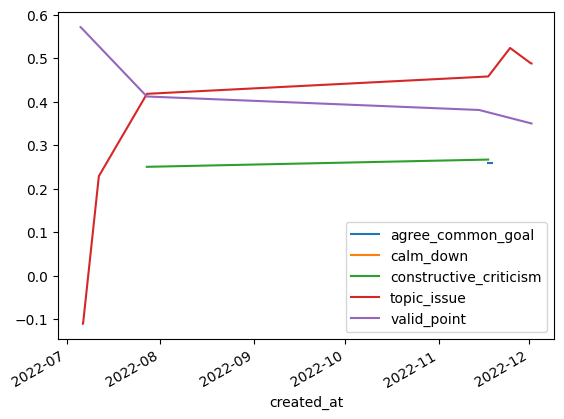

In [6]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

top_5_titles = df_rel_highest_icr.head(5)
df_rel_top_5 = df_rel_with_krippendorf[df_rel_with_krippendorf["grouped_titles"].isin(top_5_titles.index.to_list())]
#df_rel_top_5.reset_index(inplace=True)

fig, ax = plt.subplots()

for key, grp in df_rel_top_5.groupby(['grouped_titles']):
    if grp.empty:
        print('DataFrame is empty for title {}!'.format(key))
    if grp[grp["krippendorf"] > 0].empty:
        print('Alle 0 für {}!>'.format(key))
    ax = grp.plot(ax=ax, kind='line', y='krippendorf', label=key)
#ax.set_xlim([datetime.date(2022, 9, 15), datetime.date(2023, 1, 1)])
plt.legend(loc='best')
plt.show()
